<a href="https://colab.research.google.com/github/ServAlex/ArduinoPlayground/blob/master/vae_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
seedValue = 1
from numpy.random import seed
seed(seedValue)
from tensorflow import set_random_seed
set_random_seed(seedValue)

In [0]:
from keras.layers import Input, Dense, Lambda, Dropout
from keras.models import Model
from keras.datasets import mnist
from keras import objectives
from keras import backend as K
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
#matplotlib inline
import numpy as np
from scipy.stats import norm
from keras.callbacks import EarlyStopping

#from livelossplot import PlotLossesKeras
from IPython.display import clear_output

In [0]:
# variables/meta parameters

n_hidden = 128*2*2

z_dim = 2 
batch_size_count = 500
epochs_count = 250
beta_mu = 2.0
beta_var = 4
is_training = True

dropoutLevel1 = 0.1
dropoutLevel2 = 0.2
dropoutLevel3 = 0.2

layer_name_mu = 'layer_mu' 
layer_name_log_var = 'layer_log_var'

optimizer_name = 'Adadelta' #'Adadelta', 'rmsprop''Adagrad'

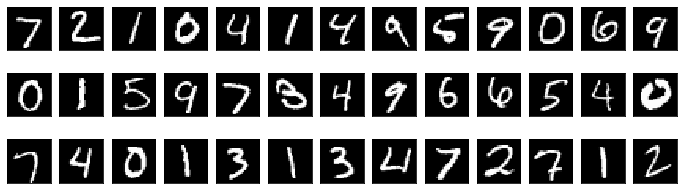

In [145]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
plt.figure(figsize=(12,12))
for i in range(39):
    ax = plt.subplot(10, 13, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [146]:
x_train = x_train.astype("float32") / 255 
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:]))) 
print('x train shape \t', x_train.shape) 

x_test = x_test.astype("float32") / 255 
x_test = x_test.reshape((len(x_test), np.prod(x_train.shape[1:])))
print('x test shape \t', x_test.shape)

img_dim = x_train.shape[1]
print('image dim \t', img_dim) 

x train shape 	 (60000, 784)
x test shape 	 (10000, 784)
image dim 	 784


In [147]:
# input
input_img = Input(shape=(img_dim,))
print('input image shape \t', input_img.shape)

# encoder
encoded = Dense(n_hidden, activation='relu')(input_img)
print('encoder stage 1 shape \t', encoded.shape)
encoded = Dropout(dropoutLevel3)(encoded)

encoded = Dense(n_hidden//2, activation='relu')(encoded)
print('encoder stage 2 shape \t' , encoded.shape)
encoded = Dropout(dropoutLevel2)(encoded)

encoded = Dense(n_hidden//4, activation='relu')(encoded)
print('encoder stage 3 shape \t' , encoded.shape)
encoded = Dropout(dropoutLevel1)(encoded)

# variational part
mu = Dense(z_dim, name = layer_name_mu)(encoded)
print('mu shape \t' , mu.shape)

log_var = Dense(z_dim, name = layer_name_log_var)(encoded)
print('log_var shape \t' , log_var.shape)

input image shape 	 (?, 784)
encoder stage 1 shape 	 (?, 512)
encoder stage 2 shape 	 (?, 256)
encoder stage 3 shape 	 (?, 128)
mu shape 	 (?, 2)
log_var shape 	 (?, 2)


In [148]:
def sampling(args):
    mu, log_var = args
    eps = tf.random.normal(shape=(batch_size_count, z_dim), mean=0., stddev=1.0)
    #print('eps shape\t', eps.shape)
    #print('mu shape\t', mu.shape)
    #print('log_var shape\t', log_var.shape)
    return mu + K.exp(log_var) * eps

z = Lambda(sampling, output_shape=(z_dim,))([mu, log_var])
print('z shape \t', z.shape)

z shape 	 (500, 2)


In [149]:
# decoder
z_decoder1 = Dense(n_hidden//4, activation='relu')
z_decoder2 = Dense(n_hidden//2, activation='relu')
z_decoder3 = Dense(n_hidden, activation='relu')
y_decoder = Dense(img_dim, activation='sigmoid')

z_decoded = z_decoder1(z)
z_decoded = Dropout(dropoutLevel1)(z_decoded)
print('decoded stage 1 shape \t', z_decoded.shape)

z_decoded = z_decoder2(z_decoded)
z_decoded = Dropout(dropoutLevel2)(z_decoded)
print('decoded stage 2 shape \t', z_decoded.shape)

z_decoded = z_decoder3(z_decoded)
z_decoded = Dropout(dropoutLevel3)(z_decoded)
print('decoded stage 3 shape \t', z_decoded.shape)

y = y_decoder(z_decoded)
print('y shape \t', y.shape)

decoded stage 1 shape 	 (500, 128)
decoded stage 2 shape 	 (500, 256)
decoded stage 3 shape 	 (500, 512)
y shape 	 (500, 784)


In [150]:
# loss
reconstruction_loss = objectives.binary_crossentropy(input_img, y) * img_dim
kl_loss = K.sum(beta_mu*K.square(mu) + beta_var*(K.exp(log_var) - log_var - 1), axis = -1)
vae_loss = reconstruction_loss + kl_loss

# build model
vae = Model(input_img, y)
vae.add_loss(vae_loss)
vae.compile(optimizer=optimizer_name)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 784)          0                                            
__________________________________________________________________________________________________
dense_50 (Dense)                (None, 512)          401920      input_15[0][0]                   
__________________________________________________________________________________________________
dropout_43 (Dropout)            (None, 512)          0           dense_50[0][0]                   
__________________________________________________________________________________________________
dense_51 (Dense)                (None, 256)          131328      dropout_43[0][0]                 
__________________________________________________________________________________________________
dropout_44

In [0]:
class PlotLearning(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.fig = plt.figure(figsize=(50,5))
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        last_loss = logs.get('loss')[0]
        last_val_loss = logs.get('val_loss')[0]

        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(last_loss)
        self.val_losses.append(last_val_loss)
        self.i += 1

        clear_output(wait=True)

        print(last_loss, last_val_loss)

        plt.plot(self.losses)
        plt.plot(self.val_losses)

        plt.show();
        
plot = PlotLearning()

150.84273 149.10634


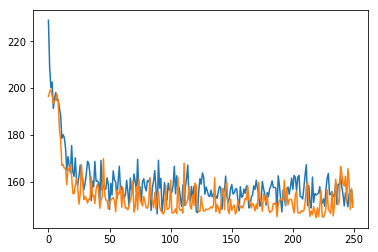

In [152]:

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

# fitting
history = vae.fit(x_train,
       shuffle=True,
       epochs=epochs_count,
       batch_size=batch_size_count,
       validation_data=(x_test, None), 
       callbacks=[plot],
       verbose=1)

In [0]:
layer_mu = Model(inputs=vae.input, outputs=vae.get_layer(layer_name_mu).output)
layer_mu_output = layer_mu.predict(x_test)

layer_var_log = Model(inputs=vae.input, outputs=vae.get_layer(layer_name_log_var).output)
layer_var_log_output = layer_var_log.predict(x_test)

In [154]:
layer_mu_output

array([[-1.2291256 , -1.790148  ],
       [ 0.59646887,  0.10672713],
       [-0.5012342 ,  2.486049  ],
       ...,
       [-0.52534145, -0.81449986],
       [-0.5513877 ,  0.7455219 ],
       [ 0.042309  ,  0.5433395 ]], dtype=float32)

(10000, 784)


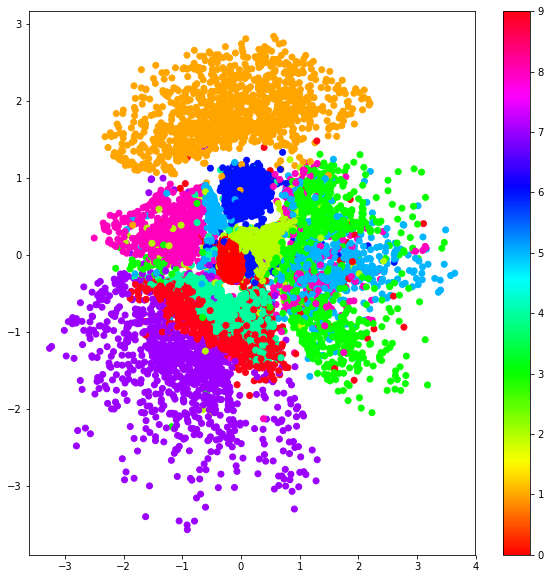

In [155]:
print(x_test.shape)

x_test_latent = layer_mu_output
plt.figure(figsize=(10, 10))
plt.hsv()
plt.scatter(x_test_latent[:, 0], x_test_latent[:, 1], c=y_test)
plt.colorbar()
plt.show()

In [156]:
layer_var_log_output

array([[-1.9447131, -1.5917952],
       [-3.0494   , -3.165151 ],
       [-2.023291 , -1.0869756],
       ...,
       [-2.7096891, -2.3573346],
       [-3.0779984, -2.7608814],
       [-3.3885412, -3.1871464]], dtype=float32)

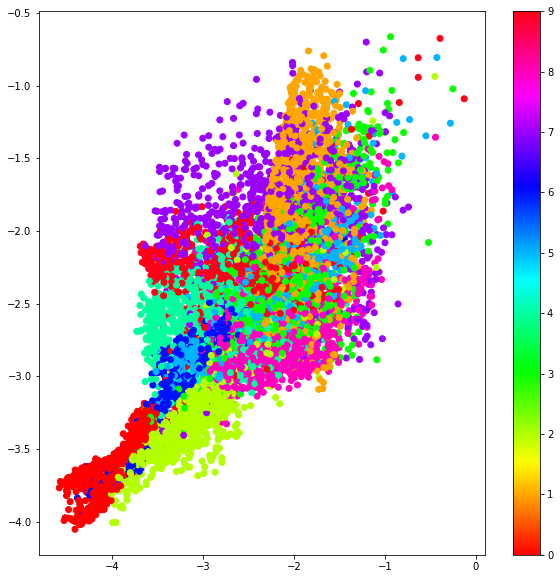

In [157]:
x_test_latent = layer_var_log_output
plt.figure(figsize=(10, 10))
plt.hsv()
plt.scatter(x_test_latent[:, 0], x_test_latent[:, 1], c=y_test)
plt.colorbar()
plt.show()

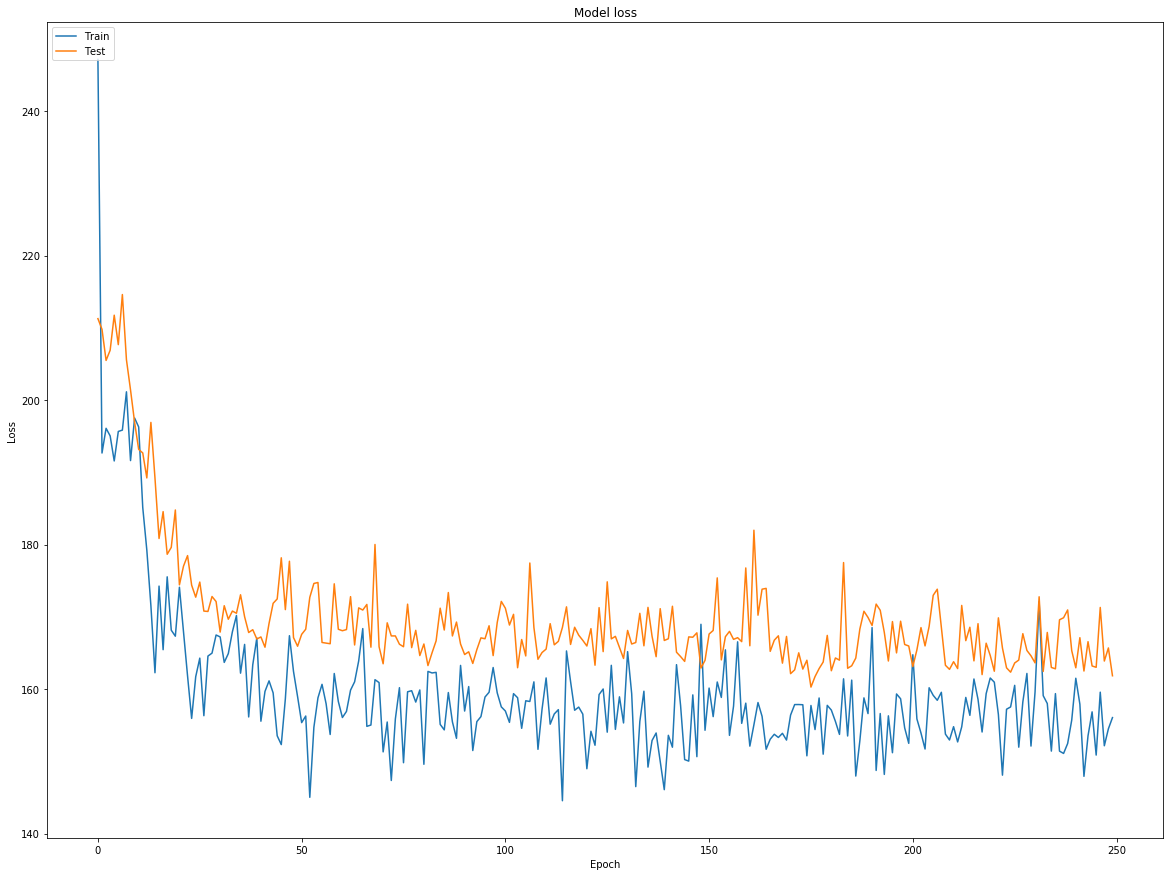

In [158]:
# Plot training & validation loss values
plt.figure(figsize=(20, 15))
plt.plot([a[1] for a in history.history['loss']])
plt.plot([a[1] for a in history.history['val_loss']])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [159]:
print(np.shape(history.history['loss']))
print(type(history.history['loss'][1]))

(250, 500)
<class 'numpy.ndarray'>


In [160]:
decoder_input = Input(shape=(z_dim,))
_z_decoded = z_decoder1(decoder_input)
_z_decoded = z_decoder2(_z_decoded)
_z_decoded = z_decoder3(_z_decoded)
_y = y_decoder(_z_decoded)
generator = Model(decoder_input, _y)
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 2)                 0         
_________________________________________________________________
dense_53 (Dense)             (None, 128)               384       
_________________________________________________________________
dense_54 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_55 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_56 (Dense)             (None, 784)               402192    
Total params: 567,184
Trainable params: 567,184
Non-trainable params: 0
_________________________________________________________________


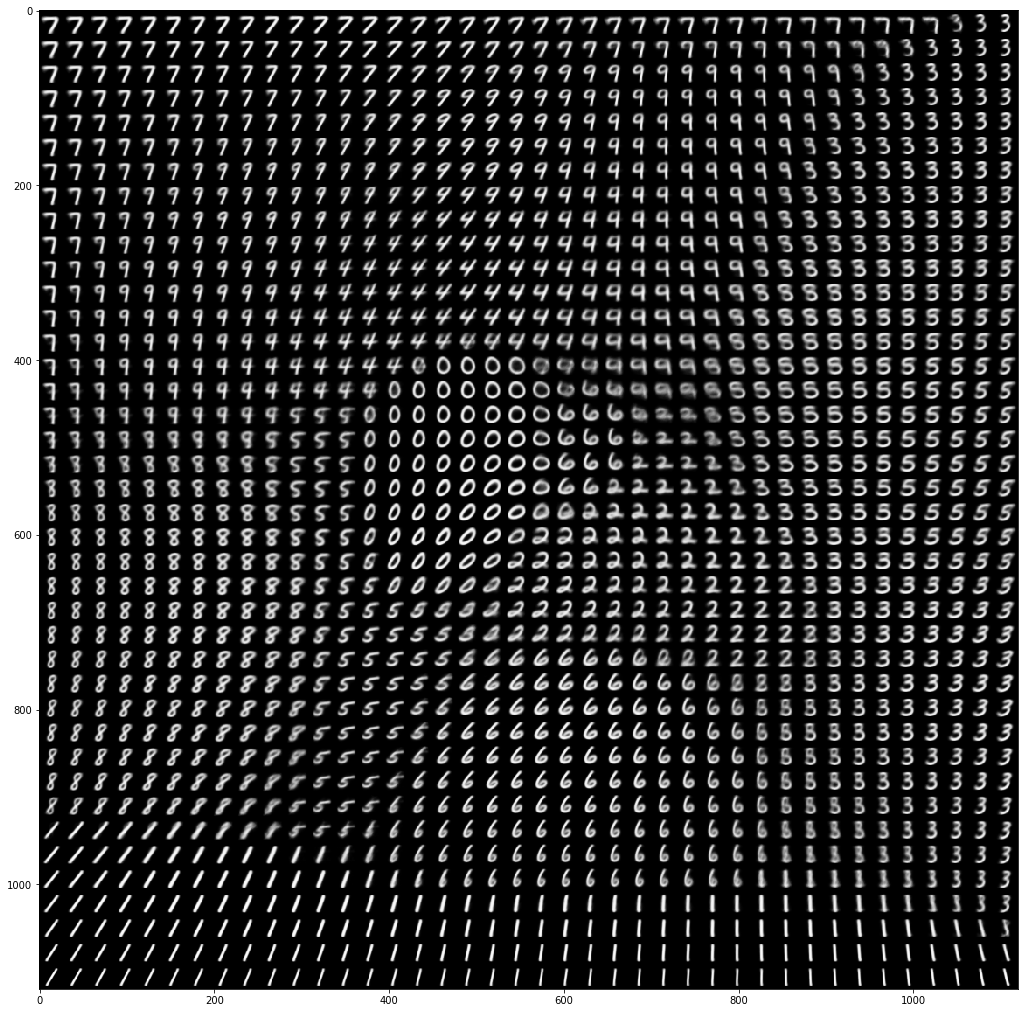

In [165]:
n = 40 # figure with 15x15 digits
digit_size = 28

figure = np.zeros((digit_size * n, digit_size * n))
grid_x = norm.ppf(np.linspace(0.01, 0.99, n)) 
grid_y = norm.ppf(np.linspace(0.01, 0.99, n))

plt.figure(figsize=(18,18))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([xi, yi])
        z_sample = np.expand_dims(z_sample, axis = 0)

        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)

        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit
plt.imshow(figure,  cmap='Greys_r')